In [1]:
import pandas as pd
from statsmodels.stats.proportion import proportion_confint as ci
from natsort import natsorted
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from matplotlib.animation import FuncAnimation

In [2]:
import sys
sys.version

'3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]'

In [3]:
def get_clean_cape_dataframe(filepath):
    """
    read the cleaned data as dataframe
    Args:
        filepath: str
        the location of the csv file
    Returns:
        dataframe
    """
    df = pd.read_csv(filepath)
    return df

In [4]:
def get_depts_and_courses_dictionary(df):
    """
    get all courses for departments
    Args:
        df: dataframe

    Returns:
        depths_courses: dict

    Examples:
    --------
        >>> df = get_clean_cape_dataframe(filepath)
        >>> get_depts_and_courses_dictionary(df)
        depths_courses = {'AAS': ['10', '11', '170', '190'], 'ANAR': ['100', '114', '115', '116', '135', '135S', '143']}

    """
    df = (df['Course_ID'].str.split(expand=True)
          .rename(columns={0: 'dept', 1: 'course'})
          .drop_duplicates())

    depts = natsorted(df.dept.unique())
    df = df.set_index(['dept', 'course']).sort_index()

    depts_courses = {dept: natsorted(df.loc[dept].index) for dept in depts}

    return depts_courses

In [5]:
def get_global_avg_time(df):
    """
    return the average time and stand deviation for all courses
    """
    gb = df[['Course_ID', 'time']]
    global_average = float(gb.mean())
    global_sd = float(gb.std())
    
    return global_average, global_sd

def get_global_avg_actual_gpa(df):
    """
    return the average time and stand deviation for all courses
    """
    gb = df[['Course_ID', 'actual_gpa']]
    global_average = float(gb.mean())
    global_sd = float(gb.std())
    
    return global_average, global_sd
    
def get_time_df(df, global_average, global_sd):
    """
    group the dataframe using the Course_ID, the average spending time for a particular course between different terms is calculated
    compare the time with other courses
    Args:
        df
    Returns:
        gb: dataframe

    Examples:
    --------
        >>> df = get_clean_cape_dataframe(filepath)
        >>> get_time_df(df)
           
        new_df:
            Course_ID  time  depart_avg_time  global_avg_time  depart_time_diff  global_time_diff              
        0       AAS 10  4.07             3.75         5.494174              0.32         -1.424174
        1      AAS 170  3.61             3.75         5.494174             -0.14         -1.884174  
        2      AAS 190  2.93             3.75         5.494174             -0.82         -2.564174  
        3     ANAR 100  3.17             4.10         5.494174             -0.93         -2.324174  
        4     ANAR 116  3.59             4.10         5.494174             -0.51         -1.904174  
    """

    df = df[['Course_ID', 'time']]
    # groupby to get average time for same courses in different quarters
    gb = df[['time', 'Course_ID']].groupby('Course_ID').mean().round(2)
    # print(gb)

    # for departments
    depths_time = {}
    depths_courses = get_depts_and_courses_dictionary(df)
    for dept, courses in depths_courses.items():
        times = []
        for course in courses:
            mask = df['Course_ID'].str.startswith(dept + ' ' + course)
            if mask.any():
                times.extend(df.loc[mask, 'time'])

        if times:
            average_time = np.mean(times)
            std_deviation = np.std(times)
            depths_time[dept] = (average_time, std_deviation)

    # for all courses
#     global_average = float(gb.mean())
#     global_sd = float(gb.std())

    df['department'] = df['Course_ID'].str.split().str[0]
    df['depart_avg_time'] = df['department'].map(lambda x: depths_time[x][0] if x in depths_time else None)

    gb = df.groupby('Course_ID').mean().round(2).reset_index()
    gb['global_avg_time'] = global_average
    gb['depart_time_diff'] = gb['time'] - gb['depart_avg_time']
    gb['global_time_diff'] = gb['time'] - global_average

    return gb

In [6]:
def get_grade_dev_df(df):
    """
    group the dataframe using the Course_ID, the average expected and actual gpa for a particular course between different terms is calculated
    compare the expected gpa and actual gpa
    Args:
        df
    Returns:
        gb: dataframe

    Examples:
    --------
        >>> df = get_clean_cape_dataframe(filepath)
        >>> get_grade_dev_df(df)

        new_df:
                Course_ID  expected_gpa  actual_gpa   dev
            0       AAS 10          3.79        3.56 -0.23
            1      AAS 170          3.89        3.68 -0.21
            2      AAS 190          3.86        4.00  0.14
            3     ANAR 100          3.33        3.30 -0.03
            4     ANAR 116          3.70        3.35 -0.35
            ...        ...           ...         ...   ...
            1205   VIS 70N          3.78        3.60 -0.18
            1206    VIS 80          3.84        3.82 -0.02
            1207  WCWP 100          3.54        3.49 -0.05
            1208  WCWP 10A          3.73        3.65 -0.08
            1209  WCWP 10B          3.55        3.50 -0.05
                            
    """
    df = df[['Course_ID', 'expected_gpa', 'actual_gpa']]

    # groupby to get the mean grade and round to 2 decimal places
    gb = df.groupby('Course_ID').mean().round(2).reset_index()
    gb['dev'] = gb['actual_gpa'] - gb['expected_gpa']

    return gb


In [7]:
def get_class_rmd_df(df):
    """
    group the dataframe using the Course_ID, the average class recommendation ratio for a particular course between different terms is calculated
    Args:
        df
    Returns:
        gb: dataframe

    Examples:
    --------
        >>> df = get_clean_cape_dataframe(filepath)
        >>> get_class_rmd_df(df)

        new_df:
             Course_ID  rmd_class
        0       AAS 10      85.68
        1       AAS 11      93.50
        2      AAS 170      94.45
        3      AAS 190     100.00
        4     ANAR 100     100.00
        ...        ...        ...
        2447    VIS 84      80.55
        2448     VIS 9      80.60
        2449  WCWP 100      92.66
        2450  WCWP 10A      91.66
        2451  WCWP 10B      90.33
    """
    df = df[['Course_ID', 'rmd_class']]
    # groupby to get the mean course recommendation ratio and round to 2 decimal places
    gb = df.groupby(['Course_ID']).mean().round(2).reset_index()
    
    return gb

In [8]:
def get_instr_rmd_df(df):
    """
    group the dataframe using the Course_ID, the average instructor recommendation ratio for a particular course between different terms is calculated
    Args:
        df
    Returns:
        gb: dataframe

    Examples:
    --------
        >>> df = get_clean_cape_dataframe(filepath)
        >>> get_instr_rmd_df(df):

        new_df:
                Course_ID                        instr  rmd_instr
        0       AAS 10    Butler, Elizabeth Annette      88.63
        1      AAS 170    Butler, Elizabeth Annette      88.90
        2      AAS 190  Puritty, Chandler Elizabeth     100.00
        3     ANAR 100                Fortier, Jana     100.00
        4     ANAR 116            Shtienberg, Gilad     100.00
        ...        ...                          ...        ...
        2256  WCWP 10A              Savage, Sarah S     100.00
        2257  WCWP 10A                Susi, Natalie      97.10
        2258  WCWP 10B            Gagnon, Jeffrey C      95.80
        2259  WCWP 10B           Tocki, Jasmine Rae     100.00
        2260  WCWP 10B         Welji, Haleema Nazir      93.30
    """
    df = df[['Course_ID', 'instr', 'rmd_instr']]

    # groupby to get the mean grade and round to 2 decimal places
    gb = df.groupby(['Course_ID','instr']).mean().round(2).reset_index()
    
    return gb

In [9]:
df = get_clean_cape_dataframe('data_clean.csv')

In [10]:
df

,instr,term,enroll,evals,rmd_class,rmd_instr,time,Course_ID,Course_Name,expected_grade,expected_gpa,actual_grade,actual_gpa
0,"Butler, Elizabeth Annette",SP23,66,48,93.5,100.0,2.80,AAS 10,Intro/African-American Studies (A),A-,3.84,B+,3.67
1,"Butler, Elizabeth Annette",SP23,20,7,100.0,100.0,2.50,AAS 170,Legacies of Research (A),A-,3.86,A-,3.92
2,"Shtienberg, Gilad",SP23,26,6,100.0,83.3,3.83,ANAR 115,Coastal Geomorphology/Environ (A),B+,3.50,B,3.07
3,"Braswell, Geoffrey E.",SP23,22,9,100.0,100.0,5.17,ANAR 155,Stdy Abrd: Ancient Mesoamerica (A),A,4.00,A,4.00
4,"Hrvoj Mihic, Branka",SP23,22,4,100.0,100.0,2.50,ANBI 111,Human Evolution (A),A,4.00,B-,2.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15400,"Blomstedt, Elizabeth Ann",SP19,20,6,100.0,100.0,4.50,WCWP 100,Academic Writing (B),B+,3.60,B+,3.42
15401,"McCleary, Keith Long",SP19,20,19,84.2,94.4,8.39,WCWP 100,Academic Writing (C),B-,2.95,B,3.17
15402,"Young, Mark T",SP19,20,8,75.0,87.5,8.00,WCWP 100,Academic Writing (F),B,3.13,B+,3.34
15403,"Gagnon, Jeffrey C",SP19,150,126,76.9,91.5,5.21,WCWP 10A,The Writing Course A (0),B,3.11,B,3.21


## Input the weights

Please provide your preferences for each category on a scale of 1 to 10, separated by spaces

(GPA, Time Spent, Exp vs True GPA, % Rec Course, % Rec Prof):

For example, enter: 10 10 5 5 5

In [11]:
user_input = input("Enter ratings separated by spaces: ")
ratings = list(map(int, user_input.split()))

def weights(ratings):
    '''
    Calculate weights based on rankings
    
    Args:
        ratings: input ratings
    
    Return:
        list: ration of ratings to sum of all ratings
    
    '''
    weights = []
    for i in ratings:
        weights.append(i/sum(ratings))
    return weights
        

Enter ratings separated by spaces: 10 10 5 5 5


In [12]:
weights = weights(ratings)
print(weights)

[0.2857142857142857, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285]


## Input the desired quarters

Please input a space seperated list of desired quarters using the corresponding numbers:

1. Fall
2. Winter
3. Spring
4. Summer Session 1
5. Summer Session 2

For example, entering `1 2 3` will select Fall, Winter, and Spring.

In [13]:
quarters = list(map(int, input("Enter quarter numbers separated by spaces: ").split(' ')))
quarters

Enter quarter numbers separated by spaces: 1


[1]

## Input the desired depeartments

Please input a space seperated list of desired quarters 
Ex: ECE CSE

In [14]:
user_input = input("Enter department names separated by spaces: ")

depts = user_input.split()

depts

Enter department names separated by spaces: ECE


['ECE']

In [15]:
maps = {1: 'FA', 2:'WI', 3:'SP', 4: 'S1', 5:'S2'}

# maps quarters to string name and slices df based on quarters
quarter_str = '|'.join([maps[q] for q in quarters])
df2 = df[df['term'].str.contains(quarter_str)].reset_index(drop=True)
df2

,instr,term,enroll,evals,rmd_class,rmd_instr,time,Course_ID,Course_Name,expected_grade,expected_gpa,actual_grade,actual_gpa
0,"Butler, Elizabeth Annette",FA22,69,20,70.0,75.0,3.70,AAS 10,Intro/African-American Studies (A),A-,3.93,A-,3.80
1,"Butler, Elizabeth Annette",FA22,31,9,88.9,88.9,3.61,AAS 170,Legacies of Research (A),A-,3.89,B+,3.68
2,"Fortier, Jana",FA22,20,3,100.0,100.0,3.17,ANAR 100,Spec Topics/Anth Archaeology (A),B+,3.33,B+,3.30
3,"Goldstein, Paul S",FA22,25,8,100.0,100.0,1.36,ANAR 143,Biblical Arch- Fact or Fiction (A),A-,3.86,A-,3.85
4,"Marchetto, Maria Carolina",FA22,30,14,100.0,100.0,1.93,ANBI 100,Special Topic/Biological Anth (A),A,4.00,A-,3.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4194,"Cho, Erica",FA19,127,78,81.6,70.7,6.47,VIS 70N,Introduction to Media (A),B+,3.64,B+,3.59
4195,"Tonies, Joshua Vanjaymes",FA19,115,96,97.9,98.9,9.43,VIS 80,Introduction to Studio Major (A),B+,3.67,B+,3.65
4196,"McCleary, Keith Long",FA19,20,20,95.0,100.0,8.70,WCWP 100,Academic Writing (B),B,3.00,B,3.28
4197,"Gagnon, Jeffrey C",FA19,697,398,74.3,86.9,4.77,WCWP 10A,The Writing Course A (0),B+,3.39,B,3.28


In [16]:
df_quarter = df2[df2['Course_ID'].str.contains('|'.join(depts))].reset_index(drop=True)
df_quarter

,instr,term,enroll,evals,rmd_class,rmd_instr,time,Course_ID,Course_Name,expected_grade,expected_gpa,actual_grade,actual_gpa
0,"Baghdadchi, Saharnaz",FA22,96,70,88.6,95.7,8.96,ECE 100,Linear Electronic Systems (A),B,3.20,C+,2.64
1,"Siegel, Paul H.",FA22,146,98,86.7,95.9,9.26,ECE 101,Linear Systems Fundamentals (A),B-,2.99,B-,2.81
2,"Hsueh, Tzu-Chien",FA22,85,68,98.5,97.1,8.00,ECE 102,Intro/Active Circuit Design (A),B,3.17,B,3.19
3,"Lomakin, Vitaliy",FA22,45,17,87.5,87.5,6.50,ECE 107,Electromagnetism (A),B,3.25,B,3.12
4,"Zeger, Kenneth A.",FA22,121,47,77.8,71.7,7.80,ECE 109,Engineering Probability&Stats (A),B-,2.89,B-,2.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,"Eldon, John",FA19,163,81,97.1,96.9,6.76,ECE 5,Intro to ECE (A),A-,3.72,B+,3.58
108,"Gilja, Vikash",FA19,163,81,97.1,100.0,6.76,ECE 5,Intro to ECE (A),A-,3.72,B+,3.58
109,"Hall, Drew A.",FA19,163,81,97.1,98.4,6.76,ECE 5,Intro to ECE (A),A-,3.72,B+,3.58
110,"Nguyen, Truong Quang",FA19,163,81,97.1,100.0,6.76,ECE 5,Intro to ECE (A),A-,3.72,B+,3.58


In [17]:
# Convert rows to numeric
df_quarter['actual_gpa'] = pd.to_numeric(df_quarter['actual_gpa'], errors='coerce')
df_quarter['rmd_class'] = pd.to_numeric(df_quarter['rmd_class'], errors='coerce')
df_quarter['rmd_instr'] = pd.to_numeric(df_quarter['rmd_instr'], errors='coerce')
df_quarter['time'] = pd.to_numeric(df_quarter['time'], errors='coerce')
df_quarter['gpa_diff'] = pd.to_numeric(df_quarter['actual_gpa'], errors='coerce') - pd.to_numeric(df_quarter['expected_gpa'], errors='coerce')

# Calculates the percentile of each entry based on other entries in filtered dataframe
df_quarter['actual_gpa_percentile'] = df_quarter['actual_gpa'].apply(lambda x: scipy.stats.percentileofscore(df_quarter['actual_gpa'], x))
df_quarter['rmd_class_percentile'] = df_quarter['rmd_class'].apply(lambda x: scipy.stats.percentileofscore(df_quarter['rmd_class'], x))
df_quarter['rmd_instr_percentile'] = df_quarter['rmd_instr'].apply(lambda x: scipy.stats.percentileofscore(df_quarter['rmd_instr'], x))
df_quarter['time_percentile'] = df_quarter['time'].apply(lambda x: scipy.stats.percentileofscore(df_quarter['time'], x))
df_quarter['gpa_diff_percentile'] = df_quarter['gpa_diff'].apply(lambda x: scipy.stats.percentileofscore(df_quarter['gpa_diff'], x))


df_quarter

,instr,term,enroll,evals,rmd_class,rmd_instr,time,Course_ID,Course_Name,expected_grade,expected_gpa,actual_grade,actual_gpa,gpa_diff,actual_gpa_percentile,rmd_class_percentile,rmd_instr_percentile,time_percentile,gpa_diff_percentile
0,"Baghdadchi, Saharnaz",FA22,96,70,88.6,95.7,8.96,ECE 100,Linear Electronic Systems (A),B,3.20,C+,2.64,-0.56,13.839286,49.107143,66.071429,58.035714,8.035714
1,"Siegel, Paul H.",FA22,146,98,86.7,95.9,9.26,ECE 101,Linear Systems Fundamentals (A),B-,2.99,B-,2.81,-0.18,28.125000,39.732143,66.964286,63.392857,41.071429
2,"Hsueh, Tzu-Chien",FA22,85,68,98.5,97.1,8.00,ECE 102,Intro/Active Circuit Design (A),B,3.17,B,3.19,0.02,58.482143,87.500000,72.321429,37.946429,72.767857
3,"Lomakin, Vitaliy",FA22,45,17,87.5,87.5,6.50,ECE 107,Electromagnetism (A),B,3.25,B,3.12,-0.13,52.678571,45.089286,36.607143,14.732143,51.785714
4,"Zeger, Kenneth A.",FA22,121,47,77.8,71.7,7.80,ECE 109,Engineering Probability&Stats (A),B-,2.89,B-,2.76,-0.13,23.214286,16.964286,12.500000,33.482143,50.892857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,"Eldon, John",FA19,163,81,97.1,96.9,6.76,ECE 5,Intro to ECE (A),A-,3.72,B+,3.58,-0.14,87.946429,84.375000,69.642857,20.089286,48.214286
108,"Gilja, Vikash",FA19,163,81,97.1,100.0,6.76,ECE 5,Intro to ECE (A),A-,3.72,B+,3.58,-0.14,87.946429,84.375000,91.964286,20.089286,48.214286
109,"Hall, Drew A.",FA19,163,81,97.1,98.4,6.76,ECE 5,Intro to ECE (A),A-,3.72,B+,3.58,-0.14,87.946429,84.375000,80.357143,20.089286,48.214286
110,"Nguyen, Truong Quang",FA19,163,81,97.1,100.0,6.76,ECE 5,Intro to ECE (A),A-,3.72,B+,3.58,-0.14,87.946429,84.375000,91.964286,20.089286,48.214286


In [18]:
# (GPA, Time Spent, Exp vs True GPA, % Rec Course, % Rec Prof):

df_quarter['rec_score'] = weights[0] * df_quarter['actual_gpa_percentile'] + \
                    weights[1] * df_quarter['time_percentile'] + \
                    weights[2] * df_quarter['gpa_diff_percentile'] + \
                    weights[3] * df_quarter['rmd_class_percentile'] + \
                    weights[4] * df_quarter['rmd_instr_percentile']
df_quarter

,instr,term,enroll,evals,rmd_class,rmd_instr,time,Course_ID,Course_Name,expected_grade,expected_gpa,actual_grade,actual_gpa,gpa_diff,actual_gpa_percentile,rmd_class_percentile,rmd_instr_percentile,time_percentile,gpa_diff_percentile,rec_score
0,"Baghdadchi, Saharnaz",FA22,96,70,88.6,95.7,8.96,ECE 100,Linear Electronic Systems (A),B,3.20,C+,2.64,-0.56,13.839286,49.107143,66.071429,58.035714,8.035714,38.137755
1,"Siegel, Paul H.",FA22,146,98,86.7,95.9,9.26,ECE 101,Linear Systems Fundamentals (A),B-,2.99,B-,2.81,-0.18,28.125000,39.732143,66.964286,63.392857,41.071429,47.257653
2,"Hsueh, Tzu-Chien",FA22,85,68,98.5,97.1,8.00,ECE 102,Intro/Active Circuit Design (A),B,3.17,B,3.19,0.02,58.482143,87.500000,72.321429,37.946429,72.767857,60.778061
3,"Lomakin, Vitaliy",FA22,45,17,87.5,87.5,6.50,ECE 107,Electromagnetism (A),B,3.25,B,3.12,-0.13,52.678571,45.089286,36.607143,14.732143,51.785714,38.329082
4,"Zeger, Kenneth A.",FA22,121,47,77.8,71.7,7.80,ECE 109,Engineering Probability&Stats (A),B-,2.89,B-,2.76,-0.13,23.214286,16.964286,12.500000,33.482143,50.892857,27.678571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,"Eldon, John",FA19,163,81,97.1,96.9,6.76,ECE 5,Intro to ECE (A),A-,3.72,B+,3.58,-0.14,87.946429,84.375000,69.642857,20.089286,48.214286,59.757653
108,"Gilja, Vikash",FA19,163,81,97.1,100.0,6.76,ECE 5,Intro to ECE (A),A-,3.72,B+,3.58,-0.14,87.946429,84.375000,91.964286,20.089286,48.214286,62.946429
109,"Hall, Drew A.",FA19,163,81,97.1,98.4,6.76,ECE 5,Intro to ECE (A),A-,3.72,B+,3.58,-0.14,87.946429,84.375000,80.357143,20.089286,48.214286,61.288265
110,"Nguyen, Truong Quang",FA19,163,81,97.1,100.0,6.76,ECE 5,Intro to ECE (A),A-,3.72,B+,3.58,-0.14,87.946429,84.375000,91.964286,20.089286,48.214286,62.946429


In [19]:
# Trunkates the course name to combine sessions of the same class
df_quarter['Course_Name'] = df_quarter['Course_Name'].str[:-3]

In [20]:
# Groups the classes the course_id and sorts based on the calculated recommendation score
df_group = df_quarter.groupby(['Course_ID','Course_Name']).mean().round(2).reset_index()
df_group = df_group.sort_values(by = 'rec_score', ascending = False).reset_index()
df_group

,index,Course_ID,Course_Name,enroll,evals,rmd_class,rmd_instr,time,expected_gpa,actual_gpa,gpa_diff,actual_gpa_percentile,rmd_class_percentile,rmd_instr_percentile,time_percentile,gpa_diff_percentile,rec_score
0,15,ECE 16,Rapid Hardware & Software Dsn,26.00,16.00,91.23,96.17,12.03,3.47,3.50,0.03,83.04,60.27,70.83,92.26,73.81,79.36
1,20,ECE 171A,Linear Control System Theory,48.00,21.00,97.75,100.00,9.22,3.48,3.52,0.04,86.16,86.16,91.96,61.38,72.32,77.93
2,12,ECE 148,Intro to Autonomous Vehicles,24.00,7.00,85.70,71.40,15.07,3.57,3.96,0.39,100.00,36.61,11.16,99.11,98.21,77.74
3,11,ECE 144,LabVIEW Programming,24.00,22.50,93.45,91.10,10.99,3.46,3.56,0.10,87.72,68.08,46.21,70.98,83.48,73.60
4,10,ECE 143,Programming for Data Analysis,98.00,68.75,95.15,96.58,7.44,3.86,3.87,0.02,96.99,74.67,70.42,28.35,72.10,66.84
5,28,ECE 5,Intro to ECE,165.00,83.57,97.67,99.19,6.82,3.74,3.57,-0.17,86.54,86.10,85.84,20.09,47.00,61.74
6,2,ECE 102,Intro/Active Circuit Design,70.25,59.75,95.25,95.20,8.30,3.07,3.20,0.12,59.93,74.33,63.95,44.31,84.93,61.67
7,23,ECE 191,Engineering Group Design Proj,24.00,3.50,87.50,83.35,10.00,3.66,3.34,-0.33,75.00,53.79,49.33,70.31,33.04,60.97
8,17,ECE 164,Analog Integrtd Circuit Design,88.50,36.50,92.08,94.40,13.66,3.25,2.90,-0.35,35.83,62.72,60.27,96.88,28.57,59.57
9,21,ECE 171B,Linear Control System Theory,29.75,16.25,93.72,79.50,8.12,3.25,3.26,0.01,67.97,69.75,43.19,43.75,69.75,58.02


In [21]:
# Presents data to user
result = df_group[['Course_ID', 'Course_Name']][0:5]

print('Based on your preferences, these are the top 5 classes we recommend for you: \n')
print(result)

Based on your preferences, these are the top 5 classes we recommend for you: 

  Course_ID                     Course_Name
0    ECE 16  Rapid Hardware & Software Dsn 
1  ECE 171A   Linear Control System Theory 
2   ECE 148   Intro to Autonomous Vehicles 
3   ECE 144            LabVIEW Programming 
4   ECE 143  Programming for Data Analysis 


In [22]:
# factor 1: Time spent
global_average, global_std = get_global_avg_time(df2)
time_factor = get_time_df(df_quarter, global_average, global_std)
time_factor_depart = time_factor[time_factor['Course_ID'].str.contains('|'.join(depts))].copy().reset_index(drop=True)
print(time_factor_depart)

   Course_ID   time  depart_avg_time  global_avg_time  depart_time_diff  \
0    ECE 100   9.25             8.89         5.814299              0.36   
1    ECE 101   9.16             8.89         5.814299              0.27   
2    ECE 102   8.30             8.89         5.814299             -0.59   
3    ECE 103   6.60             8.89         5.814299             -2.29   
4    ECE 107   7.72             8.89         5.814299             -1.17   
5    ECE 109   7.20             8.89         5.814299             -1.69   
6    ECE 111   7.48             8.89         5.814299             -1.41   
7   ECE 121A   8.90             8.89         5.814299              0.01   
8   ECE 128A   5.99             8.89         5.814299             -2.90   
9   ECE 135A   4.75             8.89         5.814299             -4.14   
10   ECE 143   7.44             8.89         5.814299             -1.45   
11   ECE 144  10.99             8.89         5.814299              2.10   
12   ECE 148  15.07      

<ipython-input-5-4f95471b5553>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['department'] = df['Course_ID'].str.split().str[0]
<ipython-input-5-4f95471b5553>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['depart_avg_time'] = df['department'].map(lambda x: depths_time[x][0] if x in depths_time else None)


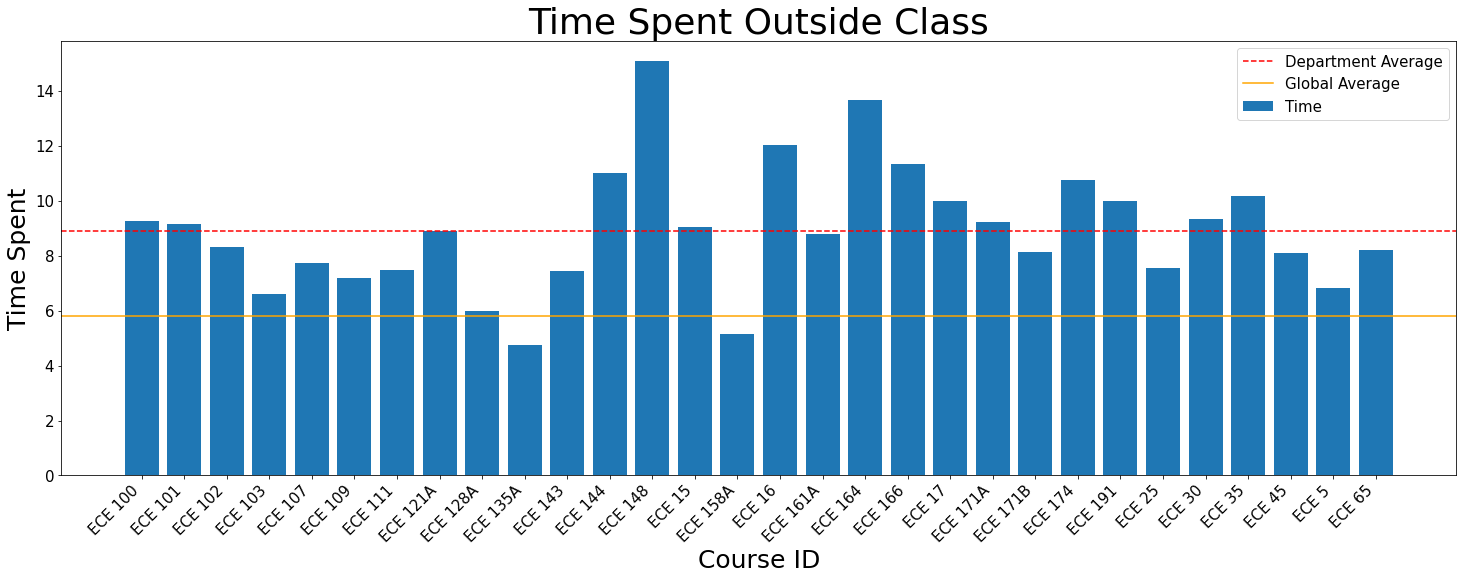

In [23]:
time_draw = time_factor_depart 

plt.figure(figsize=(25, 8))
plt.bar(time_draw['Course_ID'], time_draw['time'], label='Time')

depart_average_time = time_draw['time'].mean()
plt.axhline(y=depart_average_time, color='red', linestyle='--', label='Department Average')

global_average_time = time_draw['global_avg_time'].mean()
plt.axhline(y=global_average_time, color='orange', linestyle='-', label='Global Average')

plt.title('Time Spent Outside Class',fontsize=36)
plt.xlabel('Course ID',fontsize=25)
plt.ylabel('Time Spent',fontsize=25)

plt.xticks(rotation=45, ha='right',fontsize=15)
plt.yticks(fontsize=15)

plt.legend(fontsize=15)
plt.grid(False)
plt.show()

In [24]:
# factor 2: difference between actual gpa and expected gpa
grade_dev_factor = get_grade_dev_df(df_quarter)
grade_dev_factor_depart = grade_dev_factor[grade_dev_factor['Course_ID'].str.contains('|'.join(depts))].copy().reset_index(drop=True) # should be changed later for different inputs
# grade_dev_factor_depart = grade_dev_factor.loc[time_factor.index.str.startswith('ECE')].copy()  
print(grade_dev_factor_depart)
dev=pd.DataFrame(grade_dev_factor_depart)
dev

   Course_ID  expected_gpa  actual_gpa   dev
0    ECE 100          3.24        2.85 -0.39
1    ECE 101          3.05        3.03 -0.02
2    ECE 102          3.07        3.20  0.13
3    ECE 103          2.97        3.15  0.18
4    ECE 107          3.01        2.98 -0.03
5    ECE 109          2.93        2.76 -0.17
6    ECE 111          3.40        3.46  0.06
7   ECE 121A          3.15        3.13 -0.02
8   ECE 128A          3.43        3.55  0.12
9   ECE 135A          3.54        3.10 -0.44
10   ECE 143          3.86        3.87  0.01
11   ECE 144          3.46        3.56  0.10
12   ECE 148          3.57        3.96  0.39
13    ECE 15          3.12        2.82 -0.30
14  ECE 158A          3.36        3.19 -0.17
15    ECE 16          3.47        3.50  0.03
16  ECE 161A          2.92        2.81 -0.11
17   ECE 164          3.25        2.90 -0.35
18   ECE 166          3.12        2.78 -0.34
19    ECE 17          3.64        3.00 -0.64
20  ECE 171A          3.48        3.52  0.04
21  ECE 17

,Course_ID,expected_gpa,actual_gpa,dev
0,ECE 100,3.24,2.85,-0.39
1,ECE 101,3.05,3.03,-0.02
2,ECE 102,3.07,3.20,0.13
3,ECE 103,2.97,3.15,0.18
4,ECE 107,3.01,2.98,-0.03
5,ECE 109,2.93,2.76,-0.17
6,ECE 111,3.40,3.46,0.06
7,ECE 121A,3.15,3.13,-0.02
8,ECE 128A,3.43,3.55,0.12
9,ECE 135A,3.54,3.10,-0.44


In [27]:
# factor 3: gpa got
grade_factor_depart = grade_dev_factor_depart[['actual_gpa']].copy()
print(grade_factor_depart)

    actual_gpa
0         2.85
1         3.03
2         3.20
3         3.15
4         2.98
5         2.76
6         3.46
7         3.13
8         3.55
9         3.10
10        3.87
11        3.56
12        3.96
13        2.82
14        3.19
15        3.50
16        2.81
17        2.90
18        2.78
19        3.00
20        3.52
21        3.26
22        2.87
23        3.34
24        2.96
25        2.55
26        2.59
27        2.87
28        3.57
29        2.94


In [28]:
# gpa plot will not be plotted since it is included in the gpa difference figure. We simply add it as a weight for our recommendation system

In [29]:
# factor 4: % recommend the class
class_factor = get_class_rmd_df(df_quarter)
class_factor_depart = class_factor[class_factor['Course_ID'].str.contains('|'.join(depts))].copy().reset_index(drop=True)
print(class_factor_depart)

   Course_ID  rmd_class
0    ECE 100      90.85
1    ECE 101      89.05
2    ECE 102      95.25
3    ECE 103      81.87
4    ECE 107      74.88
5    ECE 109      76.95
6    ECE 111      71.55
7   ECE 121A      92.20
8   ECE 128A      90.62
9   ECE 135A      95.85
10   ECE 143      95.15
11   ECE 144      93.45
12   ECE 148      85.70
13    ECE 15      77.45
14  ECE 158A      90.10
15    ECE 16      91.23
16  ECE 161A      80.58
17   ECE 164      92.08
18   ECE 166      93.28
19    ECE 17      89.80
20  ECE 171A      97.75
21  ECE 171B      93.72
22   ECE 174      83.70
23   ECE 191      87.50
24    ECE 25      77.80
25    ECE 30      65.80
26    ECE 35      88.76
27    ECE 45      76.35
28     ECE 5      97.67
29    ECE 65      93.75


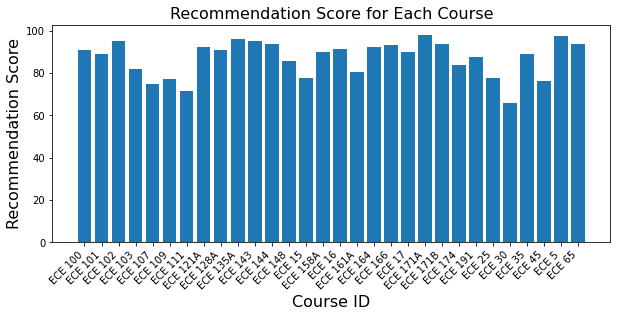

In [30]:
plt.figure(figsize=(10, 4))

plt.bar(class_factor_depart['Course_ID'], class_factor_depart['rmd_class'])

plt.xlabel('Course ID',fontsize=16)
plt.ylabel('Recommendation Score',fontsize=16)
plt.title('Recommendation Score for Each Course',fontsize=16)

plt.xticks(rotation=45, ha='right')
plt.grid(False)
plt.show()

In [31]:
# factor 5: % recommend the instructor
instr_factor = get_instr_rmd_df(df_quarter)
instr_factor_depart = instr_factor[instr_factor['Course_ID'].str.contains('|'.join(depts))].copy().reset_index(drop=True)
print(instr_factor_depart)

   Course_ID                       instr  rmd_instr
0    ECE 100        Baghdadchi, Saharnaz      95.70
1    ECE 100      Sievenpiper, Daniel F.      86.23
2    ECE 101             Siegel, Paul H.      95.28
3    ECE 102            Hsueh, Tzu-Chien      95.20
4    ECE 103                 Ng, Tse Nga      85.40
5    ECE 107            Lomakin, Vitaliy      78.18
6    ECE 109    Fazeli Chaghooshi, Arman      78.50
7    ECE 109           Zeger, Kenneth A.      78.33
8    ECE 111               Karna, Vishal      81.80
9    ECE 111         Koushanfar, Farinaz      66.27
10  ECE 121A         Esmaili, Gholamreza      88.02
11  ECE 128A  Abi Samra, Nicholas Camill      95.83
12  ECE 128A         Esmaili, Gholamreza      84.20
13  ECE 135A                Kuzum, Duygu     100.00
14   ECE 143           Unpingco, Jose H.      96.58
15   ECE 144       Phan, Alex Minh Giang      91.10
16   ECE 148             Silberman, Jack      71.40
17    ECE 15             Schurgers, Curt      88.07
18    ECE 15

## Check if a specific class is recommended or not

Type the class you are interested in and we will let you know the best professors and if we recommend it or not

Ex. ECE 5


In [34]:
class_in = input("Type you desired class:")
class_in

Type you desired class:ECE 5


'ECE 5'

In [35]:
# Creates dataframe of entries for input class id and sorts by rec_score

df_class = df_quarter[df_quarter['Course_ID'].str.contains(class_in)]
df_class_grouped = df_class.groupby('instr').mean().round(2).reset_index()
df_class_grouped = df_class_grouped.sort_values(by = 'rec_score', ascending = False).reset_index()
df_class_grouped

,index,instr,enroll,evals,rmd_class,rmd_instr,time,expected_gpa,actual_gpa,gpa_diff,actual_gpa_percentile,rmd_class_percentile,rmd_instr_percentile,time_percentile,gpa_diff_percentile,rec_score
0,1,"Gilja, Vikash",183.0,94.5,97.6,99.5,6.63,3.76,3.65,-0.12,90.40,85.49,87.50,17.41,52.90,63.07
1,4,"Nguyen, Truong Quang",163.0,81.0,97.1,100.0,6.76,3.72,3.58,-0.14,87.95,84.38,91.96,20.09,48.21,62.95
2,2,"Hall, Drew A.",163.0,81.0,97.1,98.4,6.76,3.72,3.58,-0.14,87.95,84.38,80.36,20.09,48.21,61.29
3,3,"Morris, Karcher William",150.0,76.5,98.6,100.0,7.11,3.74,3.48,-0.26,80.58,89.29,91.96,22.77,39.29,61.03
4,0,"Eldon, John",163.0,81.0,97.1,96.9,6.76,3.72,3.58,-0.14,87.95,84.38,69.64,20.09,48.21,59.76


In [36]:
# Presents data to user
result_2 = df_class_grouped[['instr']]

print('Based on your preferences, these are the professors ranked for ' + str(class_in)+ ': \n')
print(result_2)

Based on your preferences, these are the professors ranked for ECE 5: 

                     instr
0            Gilja, Vikash
1     Nguyen, Truong Quang
2            Hall, Drew A.
3  Morris, Karcher William
4              Eldon, John


In [37]:
counts =df_quarter['instr'].value_counts()
# df_group = df_group.sort_values(by = 'rec_score', ascending = False).reset_index()
df_instructor=counts[counts>1].index.tolist()
df_instructor=df_quarter[df_quarter['instr'].isin(df_instructor)]
df_instructor.sort_values(by='instr').reset_index()


,index,instr,term,enroll,evals,rmd_class,rmd_instr,time,Course_ID,Course_Name,...,expected_gpa,actual_grade,actual_gpa,gpa_diff,actual_gpa_percentile,rmd_class_percentile,rmd_instr_percentile,time_percentile,gpa_diff_percentile,rec_score
0,90,"Abi Samra, Nicholas Camill",FA19,29,10,87.5,87.5,3.93,ECE 128A,Real Wrld Pwr Grid Operation,...,3.43,A-,3.80,0.37,94.642857,45.089286,36.607143,0.892857,97.321429,52.869898
1,64,"Abi Samra, Nicholas Camill",FA20,44,15,100.0,100.0,5.83,ECE 128A,Real Wrld Pwr Grid Operation,...,3.47,B+,3.60,0.13,91.517857,95.535714,91.964286,8.928571,87.053571,67.920918
2,35,"Abi Samra, Nicholas Camill",FA21,60,27,100.0,100.0,6.19,ECE 128A,Real Wrld Pwr Grid Operation,...,3.58,B+,3.57,-0.01,85.267857,95.535714,91.964286,10.714286,70.535714,64.285714
3,46,"Atanasov, Nikolay A.",FA21,43,23,95.5,100.0,8.05,ECE 171A,Linear Control System Theory,...,3.71,B+,3.59,-0.12,90.178571,76.785714,91.964286,40.178571,53.125000,68.941327
4,17,"Atanasov, Nikolay A.",FA22,53,19,100.0,100.0,10.39,ECE 171A,Linear Control System Theory,...,3.26,B+,3.45,0.19,82.142857,95.535714,91.964286,82.589286,91.517857,86.926020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,37,"Unpingco, Jose H.",FA21,98,68,92.6,97.1,7.79,ECE 143,Programming for Data Analysis,...,3.82,A-,3.90,0.08,98.660714,65.178571,72.321429,32.142857,79.910714,68.431122
97,8,"Unpingco, Jose H.",FA22,100,64,100.0,98.4,6.79,ECE 143,Programming for Data Analysis,...,3.89,A-,3.85,-0.04,95.535714,95.535714,80.357143,22.321429,65.178571,68.112245
98,4,"Zeger, Kenneth A.",FA22,121,47,77.8,71.7,7.80,ECE 109,Engineering Probability&Stats,...,2.89,B-,2.76,-0.13,23.214286,16.964286,12.500000,33.482143,50.892857,27.678571
99,87,"Zeger, Kenneth A.",FA19,132,53,81.6,87.5,6.70,ECE 109,Engineering Probability&Stats,...,2.84,C+,2.49,-0.35,4.464286,25.892857,36.607143,16.964286,25.892857,18.750000


In [39]:
df_quarter

,instr,term,enroll,evals,rmd_class,rmd_instr,time,Course_ID,Course_Name,expected_grade,expected_gpa,actual_grade,actual_gpa,gpa_diff,actual_gpa_percentile,rmd_class_percentile,rmd_instr_percentile,time_percentile,gpa_diff_percentile,rec_score
0,"Baghdadchi, Saharnaz",FA22,96,70,88.6,95.7,8.96,ECE 100,Linear Electronic Systems,B,3.20,C+,2.64,-0.56,13.839286,49.107143,66.071429,58.035714,8.035714,38.137755
1,"Siegel, Paul H.",FA22,146,98,86.7,95.9,9.26,ECE 101,Linear Systems Fundamentals,B-,2.99,B-,2.81,-0.18,28.125000,39.732143,66.964286,63.392857,41.071429,47.257653
2,"Hsueh, Tzu-Chien",FA22,85,68,98.5,97.1,8.00,ECE 102,Intro/Active Circuit Design,B,3.17,B,3.19,0.02,58.482143,87.500000,72.321429,37.946429,72.767857,60.778061
3,"Lomakin, Vitaliy",FA22,45,17,87.5,87.5,6.50,ECE 107,Electromagnetism,B,3.25,B,3.12,-0.13,52.678571,45.089286,36.607143,14.732143,51.785714,38.329082
4,"Zeger, Kenneth A.",FA22,121,47,77.8,71.7,7.80,ECE 109,Engineering Probability&Stats,B-,2.89,B-,2.76,-0.13,23.214286,16.964286,12.500000,33.482143,50.892857,27.678571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,"Eldon, John",FA19,163,81,97.1,96.9,6.76,ECE 5,Intro to ECE,A-,3.72,B+,3.58,-0.14,87.946429,84.375000,69.642857,20.089286,48.214286,59.757653
108,"Gilja, Vikash",FA19,163,81,97.1,100.0,6.76,ECE 5,Intro to ECE,A-,3.72,B+,3.58,-0.14,87.946429,84.375000,91.964286,20.089286,48.214286,62.946429
109,"Hall, Drew A.",FA19,163,81,97.1,98.4,6.76,ECE 5,Intro to ECE,A-,3.72,B+,3.58,-0.14,87.946429,84.375000,80.357143,20.089286,48.214286,61.288265
110,"Nguyen, Truong Quang",FA19,163,81,97.1,100.0,6.76,ECE 5,Intro to ECE,A-,3.72,B+,3.58,-0.14,87.946429,84.375000,91.964286,20.089286,48.214286,62.946429


In [40]:
df_S1 = df[df['term'].str.contains('S1')].reset_index(drop=True)
df_S2 = df[df['term'].str.contains('S2')].reset_index(drop=True)
df_FA = df[df['term'].str.contains('FA')].reset_index(drop=True)
df_WI = df[df['term'].str.contains('WI')].reset_index(drop=True)
df_SP = df[df['term'].str.contains('SP')].reset_index(drop=True)


In [41]:
df_WI

,instr,term,enroll,evals,rmd_class,rmd_instr,time,Course_ID,Course_Name,expected_grade,expected_gpa,actual_grade,actual_gpa
0,"Butler, Elizabeth Annette",WI23,65,46,93.5,93.3,4.15,AAS 11,Intro Black Diasporic Studies (A),A-,3.84,A-,3.71
1,"Shtienberg, Gilad",WI23,27,9,100.0,100.0,3.61,ANAR 116,Sea Level ChangeIsrael (A),A,4.00,B+,3.62
2,"Braswell, Geoffrey E.",WI23,24,15,100.0,92.9,3.42,ANAR 135,Ancient Mediterranean Civ (A),A,4.00,A-,3.99
3,"Rodriguez, Eric Andrew",WI23,41,23,100.0,100.0,4.07,ANAR 164,Underwater Archaeology (A),A-,3.80,B+,3.63
4,"Non, Amy L",WI23,71,45,84.4,81.8,4.28,ANBI 130,Biology of Inequality (A),B+,3.42,B+,3.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4236,"Cartwright, Lisa",WI20,280,91,82.8,89.7,3.20,VIS 84,History Of Film (A),A-,3.84,A-,3.80
4237,"McCleary, Keith Long",WI20,21,21,81.0,90.5,6.12,WCWP 100,Academic Writing (A),B+,3.43,B+,3.36
4238,"Twohig, Niall Ivan",WI20,20,4,100.0,100.0,9.83,WCWP 100,Academic Writing (I),B+,3.33,B+,3.69
4239,"Gagnon, Jeffrey C",WI20,324,183,72.7,88.5,4.40,WCWP 10A,The Writing Course A (0),B+,3.47,B+,3.32


In [42]:
global_average_S1, global_std_S1 = get_global_avg_time(df_S1)
global_average_S2, global_std_S2 = get_global_avg_time(df_S2)
global_average_FA, global_std_FA = get_global_avg_time(df_FA)
global_average_WI, global_std_WI = get_global_avg_time(df_WI)
global_average_SP, global_std_SP = get_global_avg_time(df_SP)
temp_data={'Quarter':['Summer session 1','Summer session 2','Fall','Winter','Spring'],
           'Average time spent':[global_average_S1,global_average_S2,global_average_FA,global_average_WI,global_average_SP],
           'Standard deviation of time spent':[global_std_S1,global_std_S2,global_std_FA,global_std_WI,global_std_SP]
    
}
time_dif_of_summer=pd.DataFrame(temp_data)
time_dif_of_summer
# global_average_S1,global_average_S2,global_average_WI


# time_factor = get_time_df(df_S1, global_average, global_std)
# time_factor_depart = time_factor[time_factor['Course_ID'].str.contains('|'.join(depts))].copy().reset_index(drop=True)
# print(time_factor_depart)

,Quarter,Average time spent,Standard deviation of time spent
0,Summer session 1,6.880363,2.436270
1,Summer session 2,6.876703,2.562852
2,Fall,5.814299,2.264603
3,Winter,5.786296,2.318146
4,Spring,5.797604,2.357134


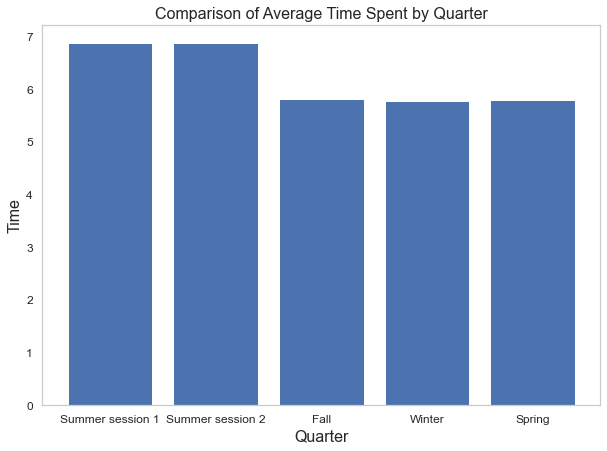

In [43]:
sns.set(style="whitegrid") 

plt.figure(figsize=(10, 7))
# sns.barplot(x='Quarter', y='Data_1', data=df, color='blue', label='Data 1')
# sns.barplot(x='X_values', y='Data_2', data=df, color='orange', label='Data 2')
quarters = time_dif_of_summer['Quarter']
avg_time_spent = time_dif_of_summer['Average time spent']
std_dev_time_spent = time_dif_of_summer['Standard deviation of time spent']

plt.bar(quarters, avg_time_spent, label='Average time spent')


# plt.bar(quarters, std_dev_time_spent, bottom=avg_time_spent, label='Standard deviation of time spent')


plt.xlabel('Quarter',fontsize=16)
plt.ylabel('Time',fontsize=16)
plt.title('Comparison of Average Time Spent by Quarter',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.legend()
plt.grid(False)
# 显示图形



In [44]:
Gglobal_average_S1, Gglobal_std_S1 = get_global_avg_actual_gpa(df_S1)
Gglobal_average_S2, Gglobal_std_S2 = get_global_avg_actual_gpa(df_S2)
Gglobal_average_FA, Gglobal_std_FA = get_global_avg_actual_gpa(df_FA)
Gglobal_average_WI, Gglobal_std_WI = get_global_avg_actual_gpa(df_WI)
Gglobal_average_SP, Gglobal_std_SP = get_global_avg_actual_gpa(df_SP)
temp_data_2={'Quarter':['Summer session 1','Summer session 2','Fall','Winter','Spring'],
           'Average Acutal GPA':[Gglobal_average_S1,Gglobal_average_S2,Gglobal_average_FA,Gglobal_average_WI,Gglobal_average_SP],
           'Standard Deviation of Actual GPA':[Gglobal_std_S1,Gglobal_std_S2,Gglobal_std_FA,Gglobal_std_WI,Gglobal_std_SP]
    
}
GPA_dif_of_summer=pd.DataFrame(temp_data_2)
GPA_dif_of_summer
# global_average_S1,global_average_S2,global_average_WI


# time_factor = get_time_df(df_S1, global_average, global_std)
# time_factor_depart = time_factor[time_factor['Course_ID'].str.contains('|'.join(depts))].copy().reset_index(drop=True

,Quarter,Average Acutal GPA,Standard Deviation of Actual GPA
0,Summer session 1,3.328183,0.404208
1,Summer session 2,3.324796,0.409667
2,Fall,3.343479,0.403809
3,Winter,3.399484,0.391423
4,Spring,3.439003,0.389045


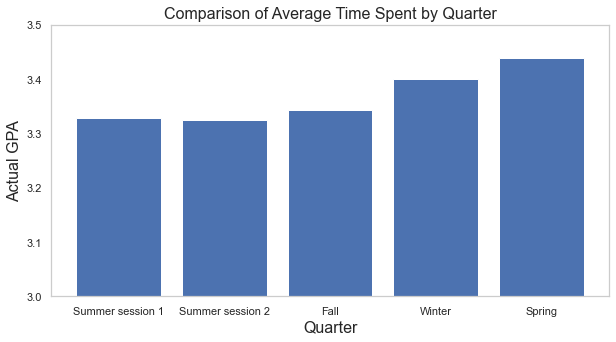

In [61]:
sns.set(style="whitegrid") 

plt.figure(figsize=(10, 5))
# sns.barplot(x='Quarter', y='Data_1', data=df, color='blue', label='Data 1')
# sns.barplot(x='X_values', y='Data_2', data=df, color='orange', label='Data 2')
quarters = GPA_dif_of_summer['Quarter']
avg_gpa = GPA_dif_of_summer['Average Acutal GPA']
std_dev_gpa = GPA_dif_of_summer['Standard Deviation of Actual GPA']

plt.bar(quarters, avg_gpa, label='Average Actual GPA')


# plt.bar(quarters, std_dev_gpa, bottom=avg_gpa, label='Standard Deviation of Actual GPA')
plt.ylim(0,4)

plt.xlabel('Quarter',fontsize=16)
plt.ylabel('Actual GPA',fontsize=16)
plt.title('Comparison of Average Time Spent by Quarter',fontsize=16)
plt.ylim(3, 3.5)
# plt.legend()
plt.grid(False)
# index = range(len(quarters))



In [46]:
df_ECE143 = df[df['Course_ID'].str.contains('ECE 143')].reset_index(drop=True)
term_order = ['WI19','SP19','FA19', 'WI20', 'SP20', 'FA20', 'WI21', 'SP21', 'FA21', 'WI22', 'SP22', 'FA22', 'WI23', 'SP23', 'FA23']  # 自定义排序顺序
df_ECE143['term'] = pd.Categorical(df_ECE143['term'], categories=term_order, ordered=True)

One_Grade_Trend={
    
}
df_ECE143.sort_values(by='term').reset_index(drop=True)

,instr,term,enroll,evals,rmd_class,rmd_instr,time,Course_ID,Course_Name,expected_grade,expected_gpa,actual_grade,actual_gpa
0,"Unpingco, Jose H.",SP19,100,58,100.0,100.0,6.46,ECE 143,Programming for Data Analysis (A),A-,3.89,A-,3.80
1,"Unpingco, Jose H.",FA19,101,81,91.3,92.5,7.64,ECE 143,Programming for Data Analysis (A),A-,3.84,A-,3.88
2,"Unpingco, Jose H.",WI20,96,73,98.6,98.6,6.34,ECE 143,Programming for Data Analysis (A),A-,3.96,A-,3.94
3,"Unpingco, Jose H.",FA20,93,62,96.7,98.3,7.52,ECE 143,Programming for Data Analysis (A),A-,3.88,A-,3.86
4,"Unpingco, Jose H.",WI21,140,97,95.8,94.8,9.42,ECE 143,Programming for Data Analysis (A),A-,3.79,A-,3.87
5,"Unpingco, Jose H.",FA21,98,68,92.6,97.1,7.79,ECE 143,Programming for Data Analysis (A),A-,3.82,A-,3.90
6,"Unpingco, Jose H.",WI22,98,68,97.1,100.0,7.88,ECE 143,Programming for Data Analysis (A),A-,3.91,A-,3.88
7,"Unpingco, Jose H.",FA22,100,64,100.0,98.4,6.79,ECE 143,Programming for Data Analysis (A),A-,3.89,A-,3.85
8,"Unpingco, Jose H.",WI23,96,57,98.1,98.1,7.50,ECE 143,Programming for Data Analysis (A),A-,3.80,A-,3.82


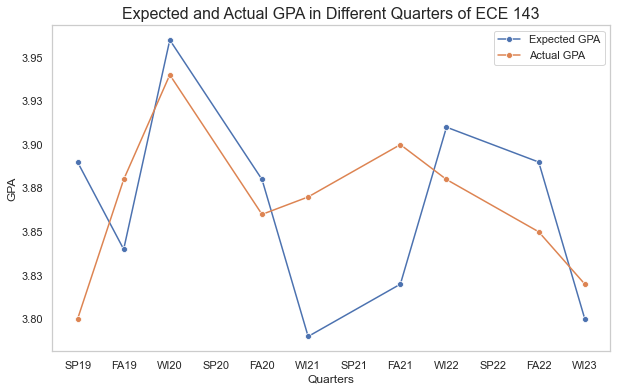

In [65]:
sns.set(style="whitegrid")  
plt.figure(figsize=(10, 6))  

sns.lineplot(x='term', y='expected_gpa', data=df_ECE143, marker='o',ci=85,label='Expected GPA')
sns.lineplot(x='term', y='actual_gpa', data=df_ECE143, marker='o',ci=85,label='Actual GPA')




plt.title('Expected and Actual GPA in Different Quarters of ECE 143',fontsize=16)
plt.xlabel('Quarters')
plt.ylabel('GPA')
plt.grid(False)
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))


plt.show()

In [67]:
average_gpa_per_term = df.groupby('term')['expected_gpa','actual_gpa'].mean().reset_index()
average_gpa_per_term

<ipython-input-67-bc9931b72664>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  average_gpa_per_term = df.groupby('term')['expected_gpa','actual_gpa'].mean().reset_index()


,term,expected_gpa,actual_gpa
0,FA19,3.430651,3.272104
1,FA20,3.533137,3.399841
2,FA21,3.505387,3.323569
3,FA22,3.522990,3.373974
4,S119,3.460472,3.262123
5,S120,3.544194,3.427204
6,S121,3.479676,3.260040
7,S122,3.528933,3.342444
8,S219,3.479453,3.241592
9,S220,3.518226,3.389476


In [72]:
term_order = ['WI19','SP19','FA19', 'WI20', 'SP20', 'FA20', 'WI21', 'SP21', 'FA21', 'WI22', 'SP22', 'FA22', 'WI23', 'SP23', 'FA23']  # 自定义排序顺序
average_gpa_per_term['term'] = pd.Categorical(average_gpa_per_term['term'], categories=term_order, ordered=True)
average_gpa_per_term = average_gpa_per_term.dropna()
average_gpa_per_term.sort_values(by='term').reset_index(drop=True)

,term,expected_gpa,actual_gpa
0,SP19,3.451420,3.302901
1,FA19,3.430651,3.272104
2,WI20,3.453504,3.395102
3,SP20,3.613234,3.671831
4,FA20,3.533137,3.399841
5,WI21,3.561732,3.482647
6,SP21,3.587296,3.472938
7,FA21,3.505387,3.323569
8,WI22,3.516613,3.354723
9,SP22,3.519217,3.350230


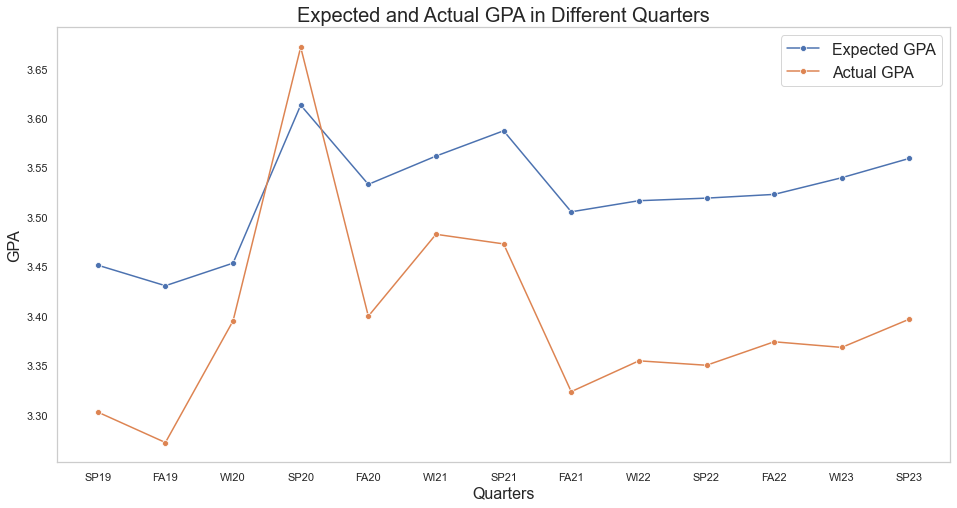

In [78]:
sns.set(style="whitegrid")  
plt.figure(figsize=(16, 8))  

sns.lineplot(x='term', y='expected_gpa', data=average_gpa_per_term, marker='o',ci=85,label='Expected GPA')
sns.lineplot(x='term', y='actual_gpa', data=average_gpa_per_term, marker='o',ci=85,label='Actual GPA')




plt.title('Expected and Actual GPA in Different Quarters',fontsize=20)
plt.xlabel('Quarters',fontsize=16)
plt.ylabel('GPA',fontsize=16)
plt.grid(False)
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
plt.legend(fontsize=16)

plt.show()

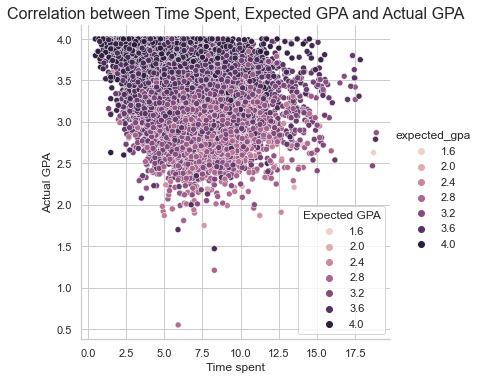

In [50]:
sns.relplot(x='time',y='actual_gpa',hue='expected_gpa',data=df)
plt.title('Correlation between Time Spent, Expected GPA and Actual GPA',fontsize=16)
plt.xlabel('Time spent')
plt.ylabel('Actual GPA')
plt.legend(title='Expected GPA')

# plt.legend(title='Expected GPA')


<Figure size 1152x360 with 0 Axes>

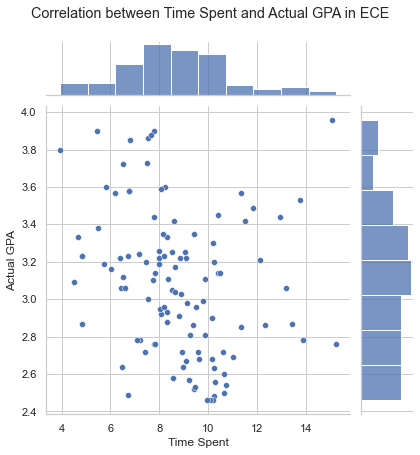

In [83]:
plt.figure(figsize=(16, 5))
joint = sns.jointplot(x='time', y='actual_gpa', data=df_quarter)


joint.set_axis_labels('Time Spent', 'Actual GPA')


joint.fig.suptitle('Correlation between Time Spent and Actual GPA in ECE', y=1.05)
plt.show()

In [106]:
df_below= df[df['rmd_class'] <85]

<Figure size 1152x360 with 0 Axes>

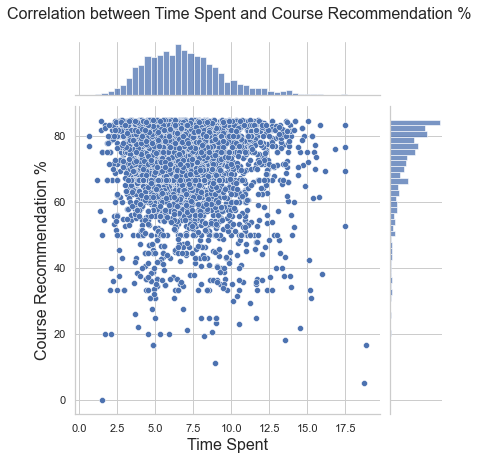

In [107]:
plt.figure(figsize=(16, 5))
joint = sns.jointplot(x='time', y='rmd_class', data=df_below)


joint.set_axis_labels('Time Spent', 'Course Recommendation %',fontsize=16)


joint.fig.suptitle('Correlation between Time Spent and Course Recommendation %', y=1.05,fontsize=16)
plt.show()

<Figure size 1152x360 with 0 Axes>

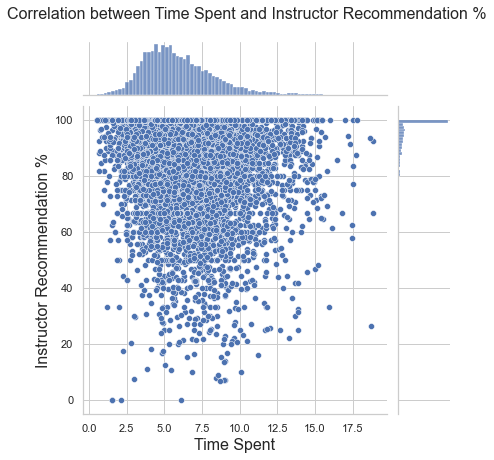

In [87]:
plt.figure(figsize=(16, 5))
joint = sns.jointplot(x='time', y='rmd_instr', data=df)

joint.set_axis_labels('Time Spent', 'Instructor Recommendation %',fontsize=16)

joint.fig.suptitle('Correlation between Time Spent and Instructor Recommendation %', y=1.05,fontsize=16)
plt.show()

<Figure size 1152x360 with 0 Axes>

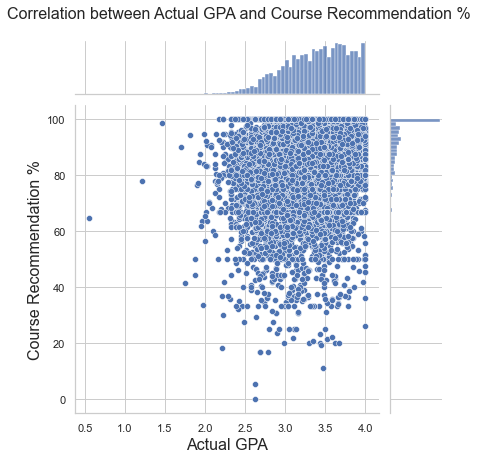

In [89]:
plt.figure(figsize=(16, 5))
joint = sns.jointplot(x='actual_gpa', y='rmd_class', data=df)

joint.set_axis_labels('Actual GPA', 'Course Recommendation %',fontsize=16)

joint.fig.suptitle('Correlation between Actual GPA and Course Recommendation %', y=1.05,fontsize=16)
plt.show()

<Figure size 1152x360 with 0 Axes>

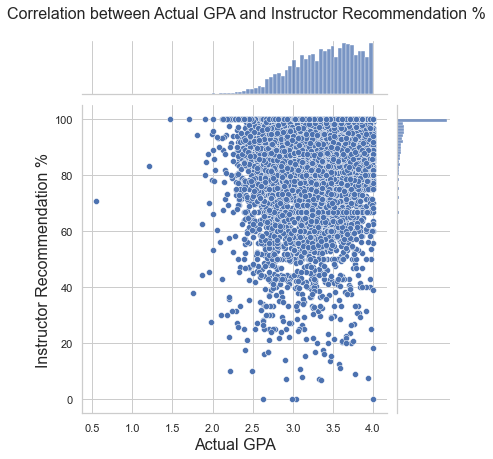

In [90]:
plt.figure(figsize=(16, 5))
joint = sns.jointplot(x='actual_gpa', y='rmd_instr', data=df)

joint.set_axis_labels('Actual GPA', 'Instructor Recommendation %',fontsize=16)

joint.fig.suptitle('Correlation between Actual GPA and Instructor Recommendation %', y=1.05,fontsize=16)
plt.show()

In [73]:
df_worst=df_quarter.sort_values(by='rmd_class').reset_index(drop=True)


In [74]:
df_worst_50=df_worst.head(50)
df_worst_50

,instr,term,enroll,evals,rmd_class,rmd_instr,time,Course_ID,Course_Name,expected_grade,expected_gpa,actual_grade,actual_gpa,gpa_diff,actual_gpa_percentile,rmd_class_percentile,rmd_instr_percentile,time_percentile,gpa_diff_percentile,rec_score
0,"Koushanfar, Farinaz",FA21,92,42,51.2,46.3,8.30,ECE 111,Advanced Digital Design Proj,B,3.10,B+,3.33,0.23,74.553571,0.892857,0.892857,45.535714,94.642857,48.086735
1,"Mir Arabbaygi, Siavash",FA22,72,31,63.3,86.2,9.21,ECE 30,Intro to Computer Engineering,B-,2.81,C+,2.57,-0.24,9.821429,1.785714,33.035714,62.500000,35.267857,30.676020
2,"Schurgers, Curt",FA22,247,186,64.1,82.3,9.57,ECE 15,Engineering Computation,B-,2.91,B-,2.72,-0.19,20.089286,2.678571,25.000000,68.750000,40.178571,35.076531
3,"Liu, Zhaowei",FA22,65,34,64.5,64.5,7.81,ECE 25,Introduction to Digital Design,B,3.13,B-,2.76,-0.37,23.214286,3.571429,5.357143,34.821429,23.660714,21.237245
4,"Lomakin, Vitaliy",FA20,94,34,66.7,72.7,8.80,ECE 107,Electromagnetism,B-,2.94,B-,2.91,-0.03,35.714286,5.357143,15.178571,54.464286,66.964286,38.265306
5,"Ng, Tse Nga",FA21,27,12,66.7,66.7,7.17,ECE 103,Fundamntls/Devices & Materials,B-,2.83,B,3.24,0.41,69.642857,5.357143,6.696429,24.107143,99.107143,42.665816
6,"Lomakin, Vitaliy",FA21,60,27,66.7,70.4,8.35,ECE 107,Electromagnetism,C+,2.69,B,3.11,0.42,51.339286,5.357143,8.928571,48.214286,100.000000,44.770408
7,"Mir Arabbaygi, Siavash",FA21,85,43,68.3,73.2,9.45,ECE 30,Intro to Computer Engineering,C+,2.59,C+,2.53,-0.06,7.142857,7.142857,16.071429,66.964286,63.392857,33.545918
8,"Antipa, Nicholas A",FA22,83,37,70.6,84.8,10.23,ECE 45,Circuits and Systems,B-,2.90,C+,2.48,-0.42,3.571429,8.035714,30.357143,79.464286,19.642857,32.015306
9,"Javidi, Tara",FA19,56,33,72.4,58.6,7.40,ECE 161A,Intr/Digital Signal Processing,B-,2.87,B-,2.72,-0.15,20.089286,8.928571,2.678571,25.892857,45.535714,21.301020


In [76]:
df_best=df_quarter.sort_values(by='rmd_class',ascending=False).reset_index(drop=True)
df_best_50=df_best.head(50)
df_best_50

,instr,term,enroll,evals,rmd_class,rmd_instr,time,Course_ID,Course_Name,expected_grade,expected_gpa,actual_grade,actual_gpa,gpa_diff,actual_gpa_percentile,rmd_class_percentile,rmd_instr_percentile,time_percentile,gpa_diff_percentile,rec_score
0,"Kuzum, Duygu",FA21,20,7,100.0,100.0,4.83,ECE 135A,Semiconductor Physics,B+,3.57,B-,2.87,-0.70,32.589286,95.535714,91.964286,4.464286,4.464286,38.010204
1,"Cosman, Pamela C.",FA20,22,3,100.0,66.7,8.50,ECE 191,Engineering Group Design Proj,B+,3.33,B,3.25,-0.08,70.982143,95.535714,6.696429,49.553571,59.821429,57.589286
2,"Abi Samra, Nicholas Camill",FA21,60,27,100.0,100.0,6.19,ECE 128A,Real Wrld Pwr Grid Operation,B+,3.58,B+,3.57,-0.01,85.267857,95.535714,91.964286,10.714286,70.535714,64.285714
3,"Atanasov, Nikolay A.",FA22,53,19,100.0,100.0,10.39,ECE 171A,Linear Control System Theory,B,3.26,B+,3.45,0.19,82.142857,95.535714,91.964286,82.589286,91.517857,86.926020
4,"Siegel, Paul H.",FA20,109,39,100.0,97.4,9.42,ECE 101,Linear Systems Fundamentals,B,3.22,B+,3.35,0.13,76.339286,95.535714,74.107143,65.178571,87.053571,77.104592
5,"Ng, Tse Nga",FA19,35,17,100.0,100.0,6.03,ECE 103,Fundamntls/Devices & Materials,B,3.07,B,3.16,0.09,56.250000,95.535714,91.964286,9.821429,82.142857,57.397959
6,"Franceschetti, Massimo",FA20,35,12,100.0,100.0,4.83,ECE 158A,Data Networks I,B+,3.67,B,3.23,-0.44,67.410714,95.535714,91.964286,4.464286,16.964286,49.744898
7,"Khoshabeh, Ramsin",FA20,22,9,100.0,100.0,11.83,ECE 16,Rapid Hardware & Software Dsn,B+,3.38,B+,3.49,0.11,83.035714,95.535714,91.964286,91.964286,85.267857,88.966837
8,"Sworder, David D.",FA19,22,9,100.0,71.4,7.75,ECE 171B,Linear Control System Theory,B,3.13,B,3.10,-0.03,50.000000,95.535714,11.160714,31.250000,66.964286,48.022959
9,"Abi Samra, Nicholas Camill",FA20,44,15,100.0,100.0,5.83,ECE 128A,Real Wrld Pwr Grid Operation,B+,3.47,B+,3.60,0.13,91.517857,95.535714,91.964286,8.928571,87.053571,67.920918


In [82]:
x = get_depts_and_courses_dictionary(df)
len(x.keys())


106